In [1]:
import pandas as pd
import numpy as np
import os
import csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from cbor2 import loads
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import StratifiedKFold
import random
import shutil

# 1: Files Processing

In [2]:
raw_files_off = os.listdir('Data/Raw/Off/')
raw_files_off = ['Data/Raw/Off/' + file_name for file_name in raw_files_off] # Adds the relative path prefix to facilitate manipulation
raw_files_heavy_load = os.listdir('Data/Raw/Heavy Load/')
raw_files_heavy_load = ['Data/Raw/Heavy Load/' + file_name for file_name in raw_files_heavy_load] # Adds the relative path prefix to facilitate manipulation
raw_files_light_load = os.listdir('Data/Raw/Light Load/')
raw_files_light_load = ['Data/Raw/Light Load/' + file_name for file_name in raw_files_light_load] # Adds the relative path prefix to facilitate manipulation

In [3]:
# Just to get a sense on how the raw data looks like
# Each file has 1 minute of accelerometric data
# The sampling frequency is of 100 Hz, so there are 6000 records per file
with open(raw_files_off[0], 'rb') as file:
    data = loads(file.read())
    print(data['payload']['sensors'])
    print(data['payload']['values'][0:10])

[{'name': 'accX', 'units': 'm/s2'}, {'name': 'accY', 'units': 'm/s2'}, {'name': 'accZ', 'units': 'm/s2'}]
[[-0.08140286058187485, 0.1496376097202301, 9.690531730651855], [-0.090979665517807, 0.14844051003456116, 9.68813705444336], [-0.0933738648891449, 0.14245499670505524, 9.695320129394531], [-0.08259996026754379, 0.1364694982767105, 9.68813705444336], [-0.08738835901021957, 0.14006079733371735, 9.684545516967773], [-0.08619125932455063, 0.1412578970193863, 9.697713851928711], [-0.09576806426048279, 0.1472434103488922, 9.690531730651855], [-0.090979665517807, 0.14484919607639313, 9.68933391571045], [-0.08858546614646912, 0.1412578970193863, 9.700108528137207], [-0.08619125932455063, 0.1472434103488922, 9.68694019317627]]


In [4]:
divide_file_by = 15

def group_data(files_list, category):
    headers = ['AccX', 'AccY', 'AccZ', 'ExperimentID', 'SourceFile']
    full_data = []
    experiment = 1
    for file_name in files_list:
        file_data = []
        with(open(file_name, 'rb')) as file:
            raw_data = loads(file.read())
            file_data = raw_data['payload']['values']
            qt_records = len(file_data)
            experiment_size = qt_records/divide_file_by
            sample_id = 1
            for record in file_data:
                if(sample_id > experiment_size):
                    experiment += 1
                    sample_id = 1
                full_data.append((*record, experiment, file_name))
                sample_id += 1
        experiment += 1
    df = pd.DataFrame(full_data, columns=headers)
       
    df['Category'] = category

    return df
    

In [5]:
df_off = group_data(raw_files_off, 'Turned Off')
df_heavy_load = group_data(raw_files_heavy_load, 'Heavy Load')
df_light_load = group_data(raw_files_light_load, 'Light Load')

# Descriptive Investigation

In [6]:
# Picking up a random experiment from each category in order to analyze its values distributions
qt_experiments = len(df_off['ExperimentID'].unique())
random_experiment = random.randint(1,qt_experiments)
df_off_rand_exp = df_off.loc[df_off['ExperimentID'] == random_experiment].drop('ExperimentID', axis=1)
df_heavy_load_rand_exp = df_heavy_load.loc[df_heavy_load['ExperimentID'] == random_experiment].drop('ExperimentID', axis=1)
df_light_load_rand_exp = df_light_load.loc[df_light_load['ExperimentID'] == random_experiment].drop('ExperimentID', axis=1)

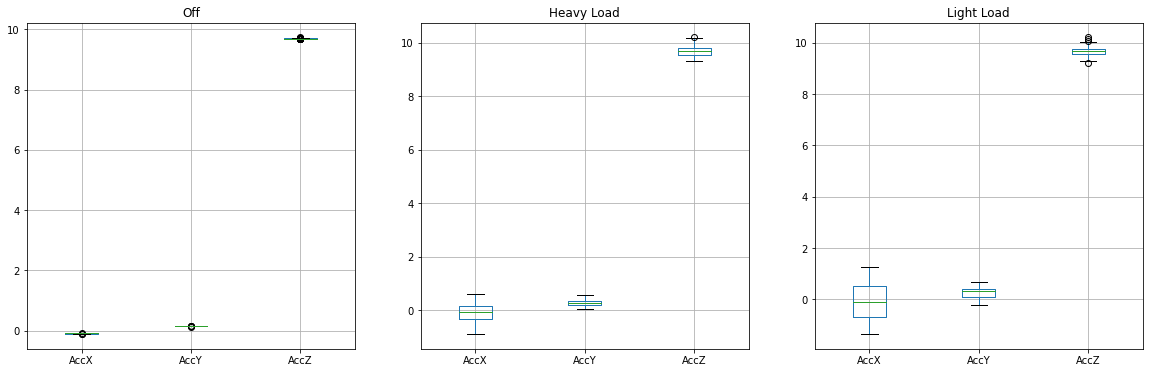

In [7]:
plt.figure(figsize=(20,6));
plt.subplot(1,3,1); df_off_rand_exp.boxplot(); plt.title('Off');
plt.subplot(1,3,2); df_heavy_load_rand_exp.boxplot(); plt.title('Heavy Load');
plt.subplot(1,3,3); df_light_load_rand_exp.boxplot(); plt.title('Light Load');

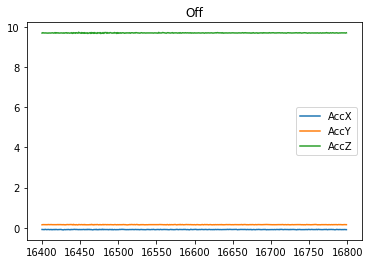

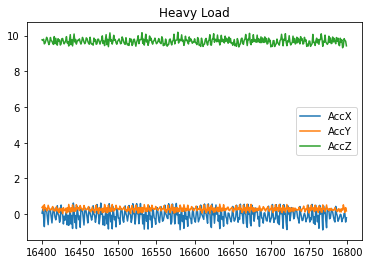

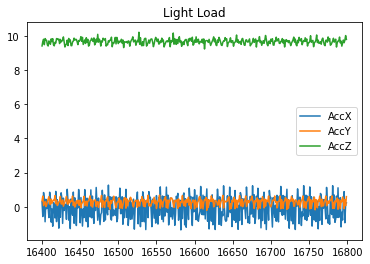

In [8]:
df_off_rand_exp.plot(); plt.title('Off');
df_heavy_load_rand_exp.plot(); plt.title('Heavy Load');
df_light_load_rand_exp.plot(); plt.title('Light Load');

In [9]:
df_off_col_names = {'AccX': 'OffAccX', 'AccY': 'OffAccY', 'AccZ': 'OffAccZ'}
df_heavy_load_col_names = {'AccX': 'HeavyAccX', 'AccY': 'HeavyAccY', 'AccZ': 'HeavyAccZ'}
df_light_load_col_names = {'AccX': 'LightAccX', 'AccY': 'LightAccY', 'AccZ': 'LightAccZ'}

df_off_rand_exp_aux = df_off_rand_exp.rename(df_off_col_names, axis='columns')
df_heavy_load_rand_exp_aux = df_heavy_load_rand_exp.rename(df_heavy_load_col_names, axis='columns')
df_light_load_rand_exp_aux =df_light_load_rand_exp.rename(df_light_load_col_names, axis='columns')

df_descriptions = pd.concat([df_off_rand_exp_aux.describe(), df_heavy_load_rand_exp_aux.describe(), df_light_load_rand_exp_aux.describe()], axis=1)
df_descriptions = df_descriptions[['OffAccX', 'HeavyAccX', 'LightAccX',
                                  'OffAccY', 'HeavyAccY', 'LightAccY',
                                  'OffAccZ', 'HeavyAccZ', 'LightAccZ']]
df_descriptions

,OffAccX,HeavyAccX,LightAccX,OffAccY,HeavyAccY,LightAccY,OffAccZ,HeavyAccZ,LightAccZ
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,-0.089480,-0.078805,-0.082519,0.153190,0.282821,0.275501,9.692171,9.689026,9.668403
std,0.005559,0.354274,0.693668,0.004807,0.123537,0.208089,0.008871,0.172898,0.156616
min,-0.107739,-0.887052,-1.349133,0.137667,0.027533,-0.201113,9.661801,9.319430,9.228451
25%,-0.093374,-0.322020,-0.706888,0.149638,0.197222,0.101454,9.688137,9.549273,9.573215
50%,-0.089783,-0.067636,-0.088585,0.153229,0.277727,0.315436,9.691729,9.676765,9.678560
75%,-0.086191,0.165200,0.513856,0.156820,0.358232,0.401029,9.696517,9.799767,9.774627
max,-0.073023,0.617704,1.270124,0.168791,0.555455,0.685939,9.726444,10.189722,10.207679


# Differential Investigation

In [10]:
df_off_rand_exp['DiffAccX'] = np.diff(df_off_rand_exp['AccX'], prepend=df_off_rand_exp['AccX'].iloc[0])
df_off_rand_exp['DiffAccY'] = np.diff(df_off_rand_exp['AccY'], prepend=df_off_rand_exp['AccY'].iloc[0])
df_off_rand_exp['DiffAccZ'] = np.diff(df_off_rand_exp['AccZ'], prepend=df_off_rand_exp['AccZ'].iloc[0])

df_heavy_load_rand_exp['DiffAccX'] = np.diff(df_heavy_load_rand_exp['AccX'], prepend=df_heavy_load_rand_exp['AccX'].iloc[0])
df_heavy_load_rand_exp['DiffAccY'] = np.diff(df_heavy_load_rand_exp['AccY'], prepend=df_heavy_load_rand_exp['AccY'].iloc[0])
df_heavy_load_rand_exp['DiffAccZ'] = np.diff(df_heavy_load_rand_exp['AccZ'], prepend=df_heavy_load_rand_exp['AccZ'].iloc[0])

df_light_load_rand_exp['DiffAccX'] = np.diff(df_light_load_rand_exp['AccX'], prepend=df_light_load_rand_exp['AccX'].iloc[0])
df_light_load_rand_exp['DiffAccY'] = np.diff(df_light_load_rand_exp['AccY'], prepend=df_light_load_rand_exp['AccY'].iloc[0])
df_light_load_rand_exp['DiffAccZ'] = np.diff(df_light_load_rand_exp['AccZ'], prepend=df_light_load_rand_exp['AccZ'].iloc[0])


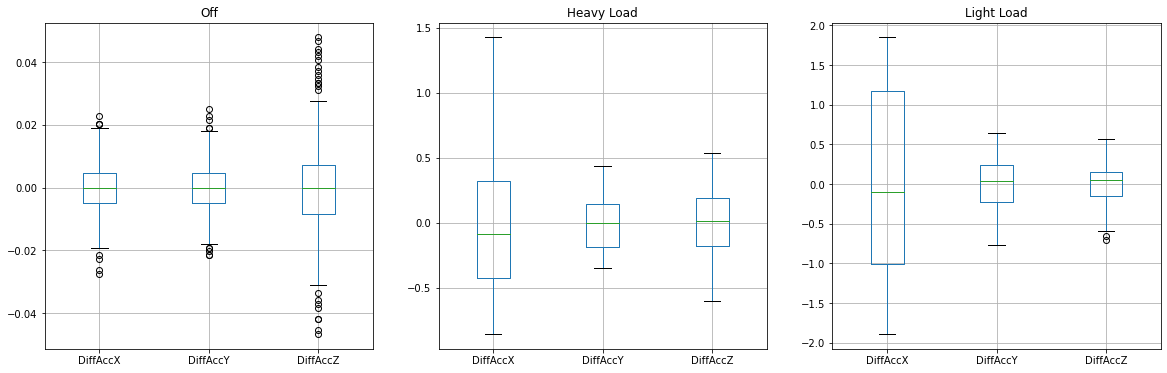

In [11]:
plt.figure(figsize=(20,6));
plt.subplot(1,3,1); df_off_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].boxplot(); plt.title('Off');
plt.subplot(1,3,2); df_heavy_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].boxplot(); plt.title('Heavy Load');
plt.subplot(1,3,3); df_light_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].boxplot(); plt.title('Light Load');

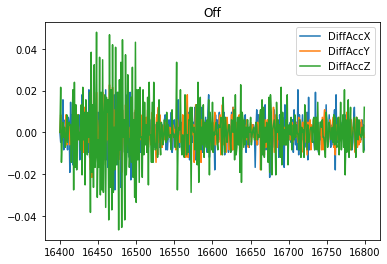

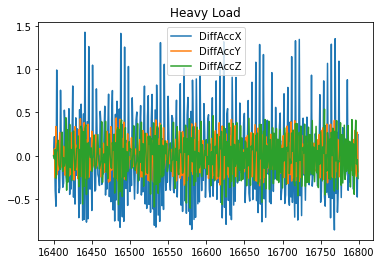

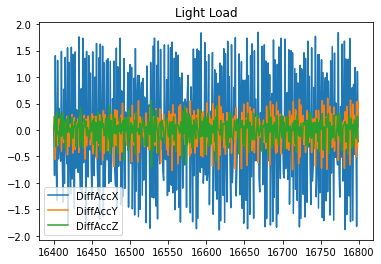

In [12]:
df_off_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].plot(); plt.title('Off');
df_heavy_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].plot(); plt.title('Heavy Load');
df_light_load_rand_exp[['DiffAccX', 'DiffAccY', 'DiffAccZ']].plot(); plt.title('Light Load');

# Defining features and preparing the train/test datasets

In [13]:
# The objectives of this function are:
#   1. To generate a file per experiment in the Curated Layer for traceability
#   2. To generate a single dataframe containing aggregated metrics per experiment (one row per experiment)

def generate_experiments_metrics(df, category):
    experiments = df.ExperimentID.unique()
    experiments_metrics = []

    experiment_path = './Data/Curated/' + category + '/' 
    
    files_list = os.listdir(experiment_path)
    for f in files_list:
        os.remove(experiment_path + f)

    for experiment in experiments:        
        if not os.path.exists(experiment_path):
            os.mkdir(experiment_path)
        
        experiment_file_name = experiment_path + 'Experiment' + str(experiment) + '.csv'

        pd.options.mode.chained_assignment = None # Disable false positive warning
        df_exp = df.loc[df['ExperimentID'] == experiment]

        df_exp.to_csv(experiment_file_name)

        df_exp['DiffAccX'] = np.diff(df_exp['AccX'], prepend=df_exp['AccX'].iloc[0])
        df_exp['DiffAccY'] = np.diff(df_exp['AccY'], prepend=df_exp['AccY'].iloc[0])
        df_exp['DiffAccZ'] = np.diff(df_exp['AccZ'], prepend=df_exp['AccZ'].iloc[0])

        # Below are the features that will be used in our ML model
        # Commented out are the ones that, based in my visual analysis, would not add value to the model
        aggregated_metrics = {
            #'MeanAccX' : df_exp.AccX.mean(),
            #'MedianAccX' : df_exp.AccX.median(), 
            'MaxAccX' : df_exp.AccX.max(),
            'MinAccX' : df_exp.AccX.min(),
            '1stQuartileAccX' : df_exp.AccX.quantile(0.25),
            'Delta1stQuartileMinAccX' : df_exp.AccX.quantile(0.25) - df_exp.AccX.min(),
            '2ndQuartileAccX' : df_exp.AccX.quantile(0.50),
            '3rdQuartileAccX' : df_exp.AccX.quantile(0.75),
            'Delta3rdQuartileMaxAccX' : df_exp.AccX.max() - df_exp.AccX.quantile(0.75),
            'DeltaMinMaxAccX' : df_exp.AccX.max() - df_exp.AccX.min(),
            'StdDevAccX' : df_exp.AccX.std(),
            #'MeanDiffAccX' : df_exp.DiffAccX.mean(),
            #'MedianDiffAccX' : df_exp.DiffAccX.median(), 
            'MaxDiffAccX' : df_exp.DiffAccX.max(),
            'MinDiffAccX' : df_exp.DiffAccX.min(),
            '1stQuartileDiffAccX' : df_exp.DiffAccX.quantile(0.25),
            'Delta1stQuartileMinDiffAccX' : df_exp.DiffAccX.quantile(0.25) - df_exp.DiffAccX.min(),
            '2ndQuartileDiffAccX' : df_exp.DiffAccX.quantile(0.50),
            '3rdQuartileDiffAccX' : df_exp.DiffAccX.quantile(0.75),
            'Delta3rdQuartileMaxDiffAccX' : df_exp.DiffAccX.max() - df_exp.DiffAccX.quantile(0.75),
            'DeltaMinMaxDiffAccX' : df_exp.DiffAccX.max() - df_exp.DiffAccX.min(),
            'StdDevDiffAccX' : df_exp.DiffAccX.std(),

            #'MeanAccY' : df_exp.AccY.mean(),
            #'MedianAccY' : df_exp.AccY.median(), 
            'MaxAccY' : df_exp.AccY.max(),
            'MinAccY' : df_exp.AccY.min(),
            '1stQuartileAccY' : df_exp.AccY.quantile(0.25),
            'Delta1stQuartileMinAccY' : df_exp.AccY.quantile(0.25) - df_exp.AccY.min(),
            '2ndQuartileAccY' : df_exp.AccY.quantile(0.50),
            '3rdQuartileAccY' : df_exp.AccY.quantile(0.75),
            'Delta3rdQuartileMaxAccY' : df_exp.AccY.max() - df_exp.AccY.quantile(0.75),
            'DeltaMinMaxAccY' : df_exp.AccY.max() - df_exp.AccY.min(),
            'StdDevAccY' : df_exp.AccY.std(),
            #'MeanDiffAccY' : df_exp.DiffAccY.mean(),
            #'MedianDiffAccY' : df_exp.DiffAccY.median(), 
            'MaxDiffAccY' : df_exp.DiffAccY.max(),
            'MinDiffAccY' : df_exp.DiffAccY.min(),
            '1stQuartileDiffAccY' : df_exp.DiffAccY.quantile(0.25),
            'Delta1stQuartileMinDiffAccY' : df_exp.DiffAccY.quantile(0.25) - df_exp.DiffAccY.min(),
            '2ndQuartileDiffAccY' : df_exp.DiffAccY.quantile(0.50),
            '3rdQuartileDiffAccY' : df_exp.DiffAccY.quantile(0.75),
            'Delta3rdQuartileMaxDiffAccY' : df_exp.DiffAccY.max() - df_exp.DiffAccY.quantile(0.75),
            'DeltaMinMaxDiffAccY' : df_exp.DiffAccY.max() - df_exp.DiffAccY.min(),
            'StdDevDiffAccY' : df_exp.DiffAccY.std(),

            #'MeanAccZ' : df_exp.AccZ.mean(),
            #'MedianAccZ' : df_exp.AccZ.median(), 
            'MaxAccZ' : df_exp.AccZ.max(),
            'MinAccZ' : df_exp.AccZ.min(),
            '1stQuartileAccZ' : df_exp.AccZ.quantile(0.25),
            'Delta1stQuartileMinAccZ' : df_exp.AccZ.quantile(0.25) - df_exp.AccZ.min(),
            '2ndQuartileAccZ' : df_exp.AccZ.quantile(0.50),
            '3rdQuartileAccZ' : df_exp.AccZ.quantile(0.75),
            'Delta3rdQuartileMaxAccZ' : df_exp.AccZ.max() - df_exp.AccZ.quantile(0.75),
            'DeltaMinMaxAccZ' : df_exp.AccZ.max() - df_exp.AccZ.min(),
            'StdDevAccZ' : df_exp.AccZ.std(),
            #'MeanDiffAccZ' : df_exp.DiffAccZ.mean(),
            #'MedianDiffAccZ' : df_exp.DiffAccZ.median(), 
            'MaxDiffAccZ' : df_exp.DiffAccZ.max(),
            'MinDiffAccZ' : df_exp.DiffAccZ.min(),
            '1stQuartileDiffAccZ' : df_exp.DiffAccZ.quantile(0.25),
            'Delta1stQuartileMinDiffAccZ' : df_exp.DiffAccZ.quantile(0.25) - df_exp.DiffAccZ.min(),
            '2ndQuartileDiffAccZ' : df_exp.DiffAccZ.quantile(0.50),
            '3rdQuartileDiffAccZ' : df_exp.DiffAccZ.quantile(0.75),
            'Delta3rdQuartileMaxDiffAccZ' : df_exp.DiffAccZ.max() - df_exp.DiffAccZ.quantile(0.75),
            'DeltaMinMaxDiffAccZ' : df_exp.DiffAccZ.max() - df_exp.DiffAccZ.min(),
            'StdDevDiffAccZ' : df_exp.DiffAccZ.std(),

            'Category' : category,
            'SourceFile' : experiment_file_name 
        }

        experiments_metrics.append(aggregated_metrics)

    return pd.DataFrame(experiments_metrics)

In [14]:
df_off_aggr = generate_experiments_metrics(df_off, 'Off')
df_heavy_load_aggr = generate_experiments_metrics(df_heavy_load, 'HeavyLoad')
df_light_load_aggr = generate_experiments_metrics(df_light_load, 'LightLoad')

In [15]:
# Preview of the dataset with aggregated values
df_off_aggr.head()

,MaxAccX,MinAccX,1stQuartileAccX,Delta1stQuartileMinAccX,2ndQuartileAccX,3rdQuartileAccX,Delta3rdQuartileMaxAccX,DeltaMinMaxAccX,StdDevAccX,MaxDiffAccX,...,MinDiffAccZ,1stQuartileDiffAccZ,Delta1stQuartileMinDiffAccZ,2ndQuartileDiffAccZ,3rdQuartileDiffAccZ,Delta3rdQuartileMaxDiffAccZ,DeltaMinMaxDiffAccZ,StdDevDiffAccZ,Category,SourceFile
0,-0.077812,-0.106542,-0.093374,0.013168,-0.089783,-0.086191,0.008380,0.028730,0.005075,0.017957,...,-0.027534,-0.004788,0.022745,0.0,0.005985,0.021547,0.055066,0.008449,Off,./Data/Curated/Off/Experiment1.csv
1,-0.071826,-0.106542,-0.093374,0.013168,-0.089783,-0.087388,0.015562,0.034716,0.005047,0.022745,...,-0.025139,-0.004788,0.020350,0.0,0.004788,0.017957,0.047884,0.007383,Off,./Data/Curated/Off/Experiment2.csv
2,-0.077812,-0.105345,-0.093374,0.011971,-0.089783,-0.087089,0.009278,0.027533,0.005014,0.021548,...,-0.028730,-0.004788,0.023942,0.0,0.005985,0.020351,0.055067,0.008227,Off,./Data/Curated/Off/Experiment3.csv
3,-0.076614,-0.105345,-0.093374,0.011971,-0.089783,-0.087388,0.010774,0.028730,0.004882,0.016759,...,-0.026336,-0.004788,0.021547,0.0,0.005985,0.023942,0.056263,0.008137,Off,./Data/Curated/Off/Experiment4.csv
4,-0.077812,-0.104148,-0.093374,0.010774,-0.089783,-0.087388,0.009577,0.026336,0.004691,0.020351,...,-0.026336,-0.005985,0.020350,0.0,0.004788,0.020350,0.051475,0.008042,Off,./Data/Curated/Off/Experiment5.csv


In [16]:
# Generating a single dataframe that will be split into train and test
df_full = pd.concat([df_off_aggr, df_heavy_load_aggr, df_light_load_aggr], ignore_index=True)

In [17]:
test_size = 0.2

In [18]:
# Splitting the data into train and test

X = df_full.drop('Category', axis='columns')
y = df_full['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #shuffle=True,stratify=y)

In [19]:
# Generating train and test files

train_test_path = './Data/Analytics/'

df_train = X_train.copy()
df_train['Category'] = y_train

df_test = X_test.copy()
df_test['Category'] = y_test

if not os.path.exists(train_test_path):
    os.mkdir(train_test_path)

df_train.to_csv(train_test_path + 'Train.csv')
df_test.to_csv(train_test_path + 'Test.csv')

In [20]:
try:
    X_train.drop('SourceFile', axis='columns', inplace=True)
    X_test.drop('SourceFile', axis='columns', inplace=True)
except:
    print('SourceFile column already removed')

In [21]:
X_train.head()

,MaxAccX,MinAccX,1stQuartileAccX,Delta1stQuartileMinAccX,2ndQuartileAccX,3rdQuartileAccX,Delta3rdQuartileMaxAccX,DeltaMinMaxAccX,StdDevAccX,MaxDiffAccX,...,StdDevAccZ,MaxDiffAccZ,MinDiffAccZ,1stQuartileDiffAccZ,Delta1stQuartileMinDiffAccZ,2ndQuartileDiffAccZ,3rdQuartileDiffAccZ,Delta3rdQuartileMaxDiffAccZ,DeltaMinMaxDiffAccZ,StdDevDiffAccZ
130,0.065841,-0.363919,-0.179565,0.184354,-0.052074,0.001197,0.064643,0.429759,0.115274,0.414197,...,0.105182,0.397438,-0.401029,-0.061352,0.339677,-0.007782,0.062548,0.334890,0.798467,0.161515
100,0.760159,-0.834379,-0.348057,0.486322,-0.081403,0.160711,0.599448,1.594538,0.365746,1.419762,...,0.161397,0.429759,-0.602142,-0.176273,0.425869,0.011971,0.189441,0.240318,1.031901,0.222033
117,0.712275,-0.957681,-0.456095,0.501585,-0.148441,0.293589,0.418686,1.669956,0.431275,1.180341,...,0.234101,0.670377,-0.879869,-0.215179,0.664690,0.024541,0.233435,0.436942,1.550246,0.319537
28,-0.077812,-0.106542,-0.093374,0.013168,-0.089783,-0.087388,0.009577,0.028730,0.004966,0.019154,...,0.005833,0.021547,-0.031124,-0.005985,0.025139,0.000000,0.005088,0.016460,0.052671,0.008324
75,0.791284,-1.041478,-0.391751,0.649726,-0.076016,0.245106,0.546177,1.832761,0.416270,1.731008,...,0.181505,0.606930,-0.691924,-0.183755,0.508169,-0.022745,0.201113,0.405817,1.298854,0.265356


# Selecting features and applying Machine Learning

Training dataset score: 1.0
Test dataset score: 1.0


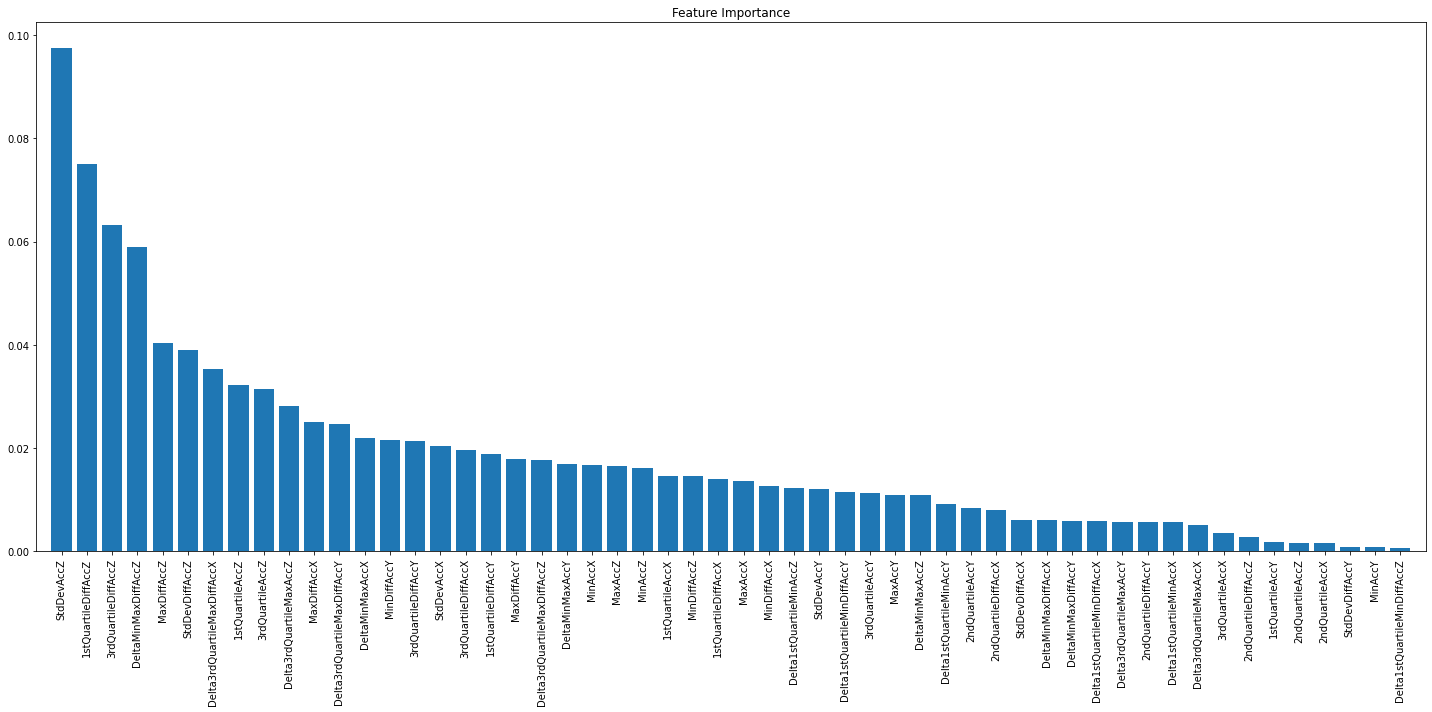


Features importance: 

 1) StdDevAccZ                     0.097578
 2) 1stQuartileDiffAccZ            0.075050
 3) 3rdQuartileDiffAccZ            0.063227
 4) DeltaMinMaxDiffAccZ            0.058913
 5) MaxDiffAccZ                    0.040423
 6) StdDevDiffAccZ                 0.038960
 7) Delta3rdQuartileMaxDiffAccX    0.035230
 8) 1stQuartileAccZ                0.032157
 9) 3rdQuartileAccZ                0.031348
10) Delta3rdQuartileMaxAccZ        0.028118
11) MaxDiffAccX                    0.024936
12) Delta3rdQuartileMaxDiffAccY    0.024730
13) DeltaMinMaxAccX                0.021983
14) MinDiffAccY                    0.021554
15) 3rdQuartileDiffAccY            0.021435
16) StdDevAccX                     0.020466
17) 3rdQuartileDiffAccX            0.019687
18) 1stQuartileDiffAccY            0.018845
19) MaxDiffAccY                    0.017883
20) Delta3rdQuartileMaxDiffAccZ    0.017710
21) DeltaMinMaxAccY                0.016972
22) MinAccX                        0.016606
23) MaxA

In [22]:
# Using a RandomForestClassifier to assess feature importance

# Fitting the model
# Random Forests do not require scaling
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

print("Training dataset score:", forest.score(X_train, y_train))
print("Test dataset score:", forest.score(X_test, y_test))

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

feat_labels = X_train.columns

plt.figure(figsize=(20,10))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

print("\nFeatures importance: \n")
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

In [29]:
# Limiting the number of features being used with SelectFromModel

# Setting a threshold of 3% for feature importance based in our random forest model
sfm = SelectFromModel(forest, threshold=0.05, prefit=True)
X_selected = sfm.transform(X_train)
print('Number of features that meet the threshold criterion:', 
      X_selected.shape[1])
print('Feature names: ')
selected_columns = []
for f in range(X_selected.shape[1]):
      print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
      selected_columns.append(feat_labels[indices[f]])

Number of features that meet the threshold criterion: 4
Feature names: 
 1) StdDevAccZ                     0.097578
 2) 1stQuartileDiffAccZ            0.075050
 3) 3rdQuartileDiffAccZ            0.063227
 4) DeltaMinMaxDiffAccZ            0.058913


In [30]:
X_train_curated = pd.DataFrame(X_selected, columns=selected_columns)
X_test_curated = X_test[selected_columns]

In [31]:
# Using SVM to classify the data based in the most relevant features

pipe_svc = make_pipeline(StandardScaler(),
                        svm.SVC())

pipe_svc.fit(X_train_curated, y_train)

print("Training dataset score:", pipe_svc.score(X_train_curated, y_train))
print("Test dataset score:", pipe_svc.score(X_test_curated, y_test))

Training dataset score: 0.9513888888888888
Test dataset score: 0.9722222222222222


In [32]:
# Writing the forecasted values to a dedicated file

forecast_analytics_file_name = './Data/Analytics/forecast.csv'

y_pred = pipe_svc.predict(X_test_curated)

df_pred = X_test.copy()
df_pred['ActualCategory'] = y_test
df_pred['ForecastedCategory'] = y_pred
df_pred['SourceFile'] = df_test['SourceFile']

df_pred.to_csv(forecast_analytics_file_name, index=False)

print("Test Dataset Forecasted")
df_pred.head()

Test Dataset Forecasted


,MaxAccX,MinAccX,1stQuartileAccX,Delta1stQuartileMinAccX,2ndQuartileAccX,3rdQuartileAccX,Delta3rdQuartileMaxAccX,DeltaMinMaxAccX,StdDevAccX,MaxDiffAccX,...,1stQuartileDiffAccZ,Delta1stQuartileMinDiffAccZ,2ndQuartileDiffAccZ,3rdQuartileDiffAccZ,Delta3rdQuartileMaxDiffAccZ,DeltaMinMaxDiffAccZ,StdDevDiffAccZ,ActualCategory,ForecastedCategory,SourceFile
93,0.606930,-0.921768,-0.360627,0.561141,-0.058658,0.164901,0.442029,1.528698,0.374646,1.425747,...,-0.196624,0.413899,0.000000,0.205602,0.263662,1.079786,0.257299,HeavyLoad,HeavyLoad,./Data/Curated/HeavyLoad/Experiment34.csv
29,-0.077812,-0.104148,-0.094571,0.009577,-0.090980,-0.087388,0.009577,0.026336,0.004823,0.017957,...,-0.004788,0.021547,0.000000,0.004788,0.022744,0.053868,0.007643,Off,Off,./Data/Curated/Off/Experiment30.csv
33,-0.076614,-0.104148,-0.093374,0.010774,-0.089783,-0.087388,0.010774,0.027533,0.005010,0.020351,...,-0.007182,0.027534,0.000000,0.007182,0.020351,0.062249,0.009740,Off,Off,./Data/Curated/Off/Experiment34.csv
30,-0.075417,-0.106542,-0.094571,0.011971,-0.090980,-0.087388,0.011971,0.031125,0.005243,0.023942,...,-0.005985,0.020351,0.000000,0.004788,0.020351,0.051476,0.008506,Off,Off,./Data/Curated/Off/Experiment31.csv
96,0.770933,-0.669179,-0.357335,0.311845,-0.105345,0.119710,0.651223,1.440112,0.355012,1.273715,...,-0.152032,0.330400,0.010175,0.171185,0.229843,0.883460,0.210499,HeavyLoad,HeavyLoad,./Data/Curated/HeavyLoad/Experiment37.csv


# Evaluating the effect of adding/removing samples to/from the training set

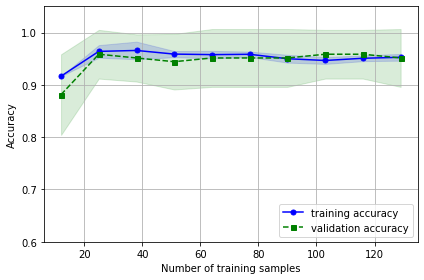

In [33]:
train_sizes, train_scores, test_scores = \
                learning_curve(estimator=pipe_svc,
                               X=X_train_curated,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.05])
plt.tight_layout()
plt.show()

# Evaluating the performance of the model accross different folds

In [34]:
# Shifting the indexes as the folds can't have gaps

X_train_indexes_shifted = X_train_curated.reset_index(drop=True)
y_train_indexes_shifted = y_train.reset_index(drop=True)

kfold = StratifiedKFold(n_splits=10,
                        random_state=1, shuffle=True).split(X_train_indexes_shifted, y_train_indexes_shifted)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_svc.fit(X_train_indexes_shifted.iloc[train], y_train_indexes_shifted.iloc[train])
    score = pipe_svc.score(X_train_indexes_shifted.iloc[test], y_train_indexes_shifted.iloc[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          y_train_indexes_shifted[train].value_counts().values, score))

print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [45 43 41], Acc: 1.000
Fold:  2, Class dist.: [46 43 40], Acc: 0.933
Fold:  3, Class dist.: [46 43 40], Acc: 0.867
Fold:  4, Class dist.: [46 43 40], Acc: 1.000
Fold:  5, Class dist.: [46 44 40], Acc: 0.929
Fold:  6, Class dist.: [46 44 40], Acc: 1.000
Fold:  7, Class dist.: [46 43 41], Acc: 0.857
Fold:  8, Class dist.: [46 43 41], Acc: 1.000
Fold:  9, Class dist.: [46 43 41], Acc: 0.929
Fold: 10, Class dist.: [46 43 41], Acc: 1.000

CV accuracy: 0.951 +/- 0.054
